In [62]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

## LASSO Example

To demonstrate, we will be using a dataset of houe prices used in a Kaggle competition.

In [22]:
df = pd.read_csv("C:/Users/jhtchns2/Downloads/houseprices/Cleaned train.csv")

<AxesSubplot:ylabel='Frequency'>

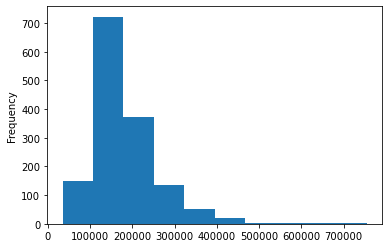

In [29]:
df['Saleprice'].plot(kind="hist")

Some minor data cleaning

In [33]:
df['decade'] = df['YearBuilt'].apply(lambda x: str(x)[:3]) + "0"

decades = pd.get_dummies(df.decade)

decades.columns = ["decade_"+x for x in decades.columns]

In [42]:
df = pd.concat([df,decades],axis=1)

How many features could we use to predict house prices?

In [165]:
features = list(df.columns)[1:5] + list(df.iloc[:,7:379].columns) + list(df.iloc[:,381:].columns)

In [166]:
len(features)

391

Oof! Is there any way we could reduce this down a little bit?

First let's scale the data.

In [167]:
X = StandardScaler().fit_transform(df[features])

y = StandardScaler().fit_transform(df[['Saleprice']])

Now let's instantiate a Lasso model. Recall that alpha here is how much we penalize large coefficients.

In [168]:
lasso_model =Lasso(alpha=.1)

lasso_model = lasso_model.fit(y=Y,X=X)

Now let's look at the coefficients:

In [169]:
lasso_model.coef_

array([ 0.        ,  0.04774875,  0.21571747,  0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.17535666,  0.        ,
        0.07229845, -0.        ,  0.1302813 ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        , -0.        ,  0.        ,
        0.01353643,  0.        ,  0.        ,  0.03675669,  0.        ,
        0.        , -0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.        , -0.        , -0.        ,  0.        ,
       -0.        , -0.        , -0.        ,  0.08096833,  0.00256433,
        0.03290653,  0.        ,  0.08091889,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        , -0.        , -0.        , -0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.  

Notice that it has zeroed out a bunch of coefficients.

In [171]:
bool_ = lasso_model.coef_!=0
print(sum(bool_))
df[features].iloc[:,bool_].columns

18


Index(['LotArea', 'OverallQual', 'TotalBsmtSF', '2ndFlrSF', 'GrLivArea',
       'Fireplaces', 'GarageArea', 'Total_Home_Quality', 'TotalSF',
       'YrBltAndRemod', 'Total_Bathrooms', 'GarageCars_log_sq',
       'Neighborhood_NoRidge', 'ExterQual_Ex', 'ExterQual_TA', 'BsmtQual_Ex',
       'BsmtExposure_Gd', 'KitchenQual_Ex'],
      dtype='object')

So that's already an improvement! Here's what happen when we choose different values of alpha

<ipython-input-173-ce0393c420dc>:6: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso_model = lasso_model.fit(y=y,X=X)
C:\Users\jhtchns2\.conda\envs\ace592\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\jhtchns2\.conda\envs\ace592\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.052702479101306, tolerance: 0.14579999999999999
  model = cd_fast.enet_coordinate_descent(


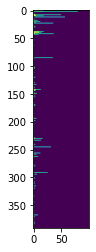

In [173]:
def get_cols(alpha,features,target):
    X = StandardScaler().fit_transform(df[features])
    y = StandardScaler().fit_transform(df[target])
    
    lasso_model =Lasso(alpha=alpha)
    lasso_model = lasso_model.fit(y=y,X=X)
    
    coefs = lasso_model.coef_
    
    return coefs!=0

Alpha = np.arange(0,1,.01)

coef_lists = [list(get_cols(a,features,["Saleprice"])) for a in Alpha]

plt.imshow(pd.DataFrame(coef_lists).T)

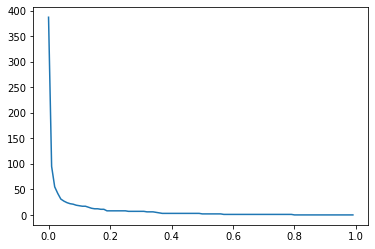

In [178]:
plt.plot(Alpha,pd.DataFrame(coef_lists).sum(axis=1))

But how do we know we got the right value of alpha?

One way is to choose them based on __prediction error__. Let's use cross validation!

In [209]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [208]:
model = Lasso(alpha=.05).fit(X_train,y_train)

y_hat = model.predict(X_test)

rmse = ((y_hat - y_test[:,0])**2).mean()
rmse 

0.13392528035639878

In [210]:
model = Lasso(alpha=.15).fit(X_train,y_train)

y_hat = model.predict(X_test)

rmse = ((y_hat - y_test[:,0])**2).mean()
rmse 

0.21947293013344027

In [211]:
def get_alpha_rmse(alpha):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
    model = Lasso(alpha=alpha).fit(X_train,y_train)

    y_hat = model.predict(X_test)

    rmse = ((y_hat - y_test[:,0])**2).mean()
    return rmse 

In [222]:
A = np.arange(.0001,1,.001)

In [223]:
rmses = [get_alpha_rmse(a) for a in A]

C:\Users\jhtchns2\.conda\envs\ace592\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.409144041023673, tolerance: 0.1132452603266032
  model = cd_fast.enet_coordinate_descent(
C:\Users\jhtchns2\.conda\envs\ace592\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3276227017619959, tolerance: 0.1132452603266032
  model = cd_fast.enet_coordinate_descent(
C:\Users\jhtchns2\.conda\envs\ace592\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.19870639902923415, tolerance: 0.1132452603266032
  model = cd_fast.enet_coordinate_descent(


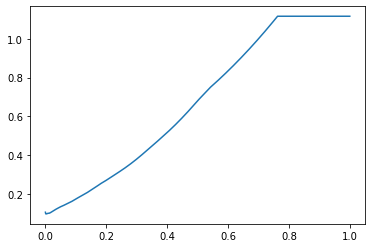

In [224]:
plt.plot(A,rmses)

So the lowest possible value is the best one.

We could have done this easier with the `LassoCV` function, which will do it with K-folds:

In [225]:
from sklearn.linear_model import LassoCV

In [226]:
Alpha = np.arange(0,1,.005)
lasso_model = LassoCV(alphas=A,cv=10)

In [227]:
lasso_model = lasso_model.fit(X,Y)

C:\Users\jhtchns2\.conda\envs\ace592\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\jhtchns2\.conda\envs\ace592\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3537807515448037, tolerance: 0.13496970798903496
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\jhtchns2\.conda\envs\ace592\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.933108938308273, tolerance: 0.13496970798903496
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\jhtchns2\.conda\envs\ace592\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525

In [241]:
list(df[features].iloc[:,lasso_model.coef_!=0].columns)

['LotFrontage',
 'LotArea',
 'OverallQual',
 'MasVnrArea',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'BsmtHalfBath',
 'FullBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageArea',
 'OpenPorchSF',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'Total_Home_Quality',
 'TotalSF',
 'YrBltAndRemod',
 'Total_sqr_footage',
 'Total_Bathrooms',
 'Total_porch_sf',
 'TotalBsmtSF_log',
 '2ndFlrSF_log',
 'LowQualFinSF_log',
 'HalfBath_log',
 'TotalSF_log',
 'GarageCars_log_sq',
 'MSSubClass_120',
 'MSSubClass_190',
 'MSSubClass_40',
 'MSSubClass_70',
 'MSSubClass_75',
 'MSSubClass_85',
 'MSSubClass_90',
 'MSZoning_C (all)',
 'MSZoning_FV',
 'MSZoning_RM',
 'Alley_Pave',
 'LotShape_IR1',
 'LotShape_IR2',
 'LotShape_IR3',
 'LandContour_HLS',
 'LandContour_Low',
 'LotConfig_Corner',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_FR3',
 'LandSlope_Mod',
 'LandSlope_Sev',
 'Neighborhood_Blmngtn',
 'Neighborhood_Blueste',
 'Neighborhood_BrDale

In [246]:
(lasso_model.coef_!=0).sum()

196

So it wanted to keep about half the variables. __What might we do in this case?__

Suppose that we wanted to train an __Elastic Net__ to check these results.

In [247]:
from sklearn.linear_model import ElasticNet, ElasticNetCV

In [263]:
model = ElasticNet(alpha=.5,l1_ratio=.5)
model = model.fit(X,Y)
model.coef_

array([ 0.        ,  0.        ,  0.19287968, -0.        , -0.        ,
       -0.        , -0.        ,  0.        ,  0.10316535,  0.        ,
        0.        , -0.        ,  0.06549987,  0.        , -0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.01288429,  0.03103155,  0.        ,
        0.        , -0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.        , -0.        , -0.        ,  0.        ,
       -0.        , -0.        , -0.        ,  0.05913308,  0.        ,
        0.        ,  0.        ,  0.05457033,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.0401778 ,
        0.        , -0.        ,  0.        ,  0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.  

How do we choose two parameters at once?

This is where we can us `GridSearchCV`:

In [264]:
from sklearn.model_selection import GridSearchCV

To tell it how we want to search, I need to supply a dictionary with the gridspace.

In [282]:
param_grid ={"alpha":np.arange(0,1.1,.025),"l1_ratio":np.arange(0,1.1,.1)}
model = GridSearchCV(ElasticNet(),param_grid,n_jobs=8) # Notice I can parallelize it!
model = model.fit(X,Y)

In [284]:
model.best_estimator_

ElasticNet(alpha=0.025, l1_ratio=0.4)

So now it tells us that the best estimator has an alpha of .025 and a mixing parameter of 0.4

In [290]:
best_coefs = model.best_estimator_.coef_

In [292]:
(best_coefs!=0).sum()

103

Still around 100 variables, so probably ok for prediction (but not great for variable selection!)